In [2]:
import pathlib

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

In [3]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [ ]:
from google.colab import drive, files
import os
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Repos/
if not os.path.exists("neural-cellular-automata"):
    !git clone https://github.com/erikhelmut/neural-cellular-automata.git
    %cd neural-cellular-automata/
else:
    %cd neural-cellular-automata/
    !git pull
#%pip install -r requirements.txt

https://github.com/jankrepl/mildlyoverfitted/tree/master/github_adventures/automata

In [4]:
class CAModel(nn.Module):
    """Cell automata model.

    Parameters
    ----------
    n_channels : int
        Number of channels of the grid.

    hidden_channels : int
        Hidden channels that are related to the pixelwise 1x1 convolution.

    fire_rate : float
        Number between 0 and 1. The lower it is the more likely it is for
        cells to be set to zero during the `stochastic_update` process.

    device : torch.device
        Determines on what device we perfrom all the computations.

    Attributes
    ----------
    update_module : nn.Sequential
        The only part of the network containing trainable parameters. Composed
        of 1x1 convolution, ReLu and 1x1 convolution.

    filters : torch.Tensor
        Constant tensor of shape `(3 * n_channels, 1, 3, 3)`.
    """
    def __init__(self, n_channels=16, hidden_channels=128, fire_rate=0.5, device=None):
        super().__init__()


        self.fire_rate = 0.5
        self.n_channels = n_channels
        self.device = device or torch.device("cpu")

        # Perceive step
        sobel_filter_ = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        scalar = 8.0

        sobel_filter_x = sobel_filter_ / scalar
        sobel_filter_y = sobel_filter_.t() / scalar
        identity_filter = torch.tensor(
                [
                    [0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0],
                ],
                dtype=torch.float32,
        )
        filters = torch.stack(
                [identity_filter, sobel_filter_x, sobel_filter_y]
        )  # (3, 3, 3)
        filters = filters.repeat((n_channels, 1, 1))  # (3 * n_channels, 3, 3)
        self.filters = filters[:, None, ...].to(
                self.device
        )  # (3 * n_channels, 1, 3, 3)

        # Update step
        self.update_module = nn.Sequential(
                nn.Conv2d(
                    3 * n_channels,
                    hidden_channels,
                    kernel_size=1,  # (1, 1)
                ),
                nn.ReLU(),
                nn.Conv2d(
                    hidden_channels,
                    n_channels,
                    kernel_size=1,
                    bias=False,
                ),
        )

        with torch.no_grad():
            self.update_module[2].weight.zero_()

        self.to(self.device)

    def perceive(self, x):
        """Approximate channelwise gradient and combine with the input.

        This is the only place where we include information on the
        neighboring cells. However, we are not using any learnable
        parameters here.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, 3 * n_channels, grid_size, grid_size)`.
        """
        return nn.functional.conv2d(x, self.filters, padding=1, groups=self.n_channels)

    def update(self, x):
        """Perform update.

        Note that this is the only part of the forward pass that uses
        trainable parameters

        Paramters
        ---------
        x : torch.Tensor
            Shape `(n_samples, 3 * n_channels, grid_size, grid_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.
        """
        return self.update_module(x)

    @staticmethod
    def stochastic_update(x, fire_rate):
        """Run pixel-wise dropout.

        Unlike dropout there is no scaling taking place.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.

        fire_rate : float
            Number between 0 and 1. The higher the more likely a given cell
            updates.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.
        """
        device = x.device

        mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).to(device, torch.float32)
        return x * mask  # broadcasted over all channels

    @staticmethod
    def get_living_mask(x):
        """Identify living cells.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, 1, grid_size, grid_size)` and the
            dtype is bool.
        """
        return (
            nn.functional.max_pool2d(
                x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1
            )
            > 0.1
        )

    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_channels, grid_size, grid_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_sample, n_channels, grid_size, grid_size)`.
        """
        pre_life_mask = self.get_living_mask(x)

        y = self.perceive(x)
        dx = self.update(y)
        dx = self.stochastic_update(dx, fire_rate=self.fire_rate)

        x = x + dx

        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).to(torch.float32)

        return x * life_mask

In [8]:
def load_image(path, size=40):
    """Load an image.

    Parameters
    ----------
    path : pathlib.Path
        Path to where the image is located. Note that the image needs to be
        RGBA.

    size : int
        The image will be resized to a square wit ha side length of `size`.

    Returns
    -------
    torch.Tensor
        4D float image of shape `(1, 4, size, size)`. The RGB channels
        are premultiplied by the alpha channel.
    """
    img = Image.open(path)
    img = img.resize((size, size), Image.ANTIALIAS)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]

    return torch.from_numpy(img).permute(2, 0, 1)[None, ...]

In [9]:
def to_rgb(img_rgba):
    """Convert RGBA image to RGB image.

    Parameters
    ----------
    img_rgba : torch.Tensor
        4D tensor of shape `(1, 4, size, size)` where the RGB channels
        were already multiplied by the alpha.

    Returns
    -------
    img_rgb : torch.Tensor
        4D tensor of shape `(1, 3, size, size)`.
    """
    rgb, a = img_rgba[:, :3, ...], torch.clamp(img_rgba[:, 3:, ...], 0, 1)
    return torch.clamp(1.0 - a + rgb, 0, 1)

In [10]:
def make_seed(size, n_channels):
    """Create a starting tensor for training.

    The only active pixels are going to be in the middle.

    Parameters
    ----------
    size : int
        The height and the width of the tensor.

    n_channels : int
        Overall number of channels. Note that it needs to be higher than 4
        since the first 4 channels represent RGBA.

    Returns
    -------
    torch.Tensor
        4D float tensor of shape `(1, n_chanels, size, size)`.
    """
    x = torch.zeros((1, n_channels, size, size), dtype=torch.float32)
    x[:, 3:, size // 2, size // 2] = 1
    return x

  0%|          | 0/2001 [00:00<?, ?it/s]

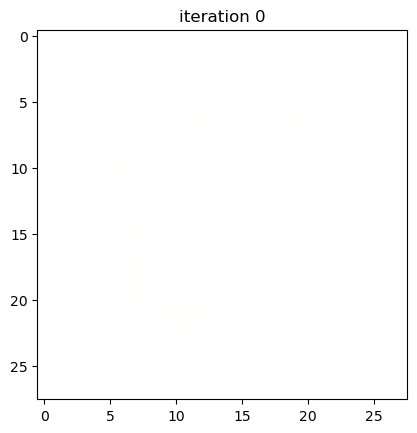

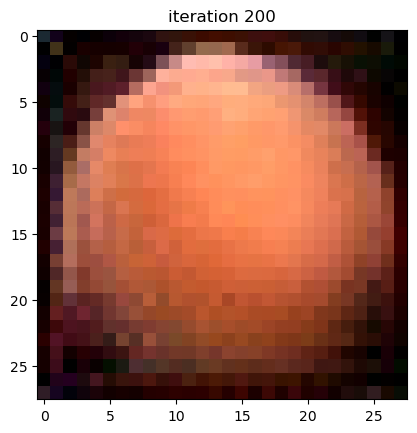

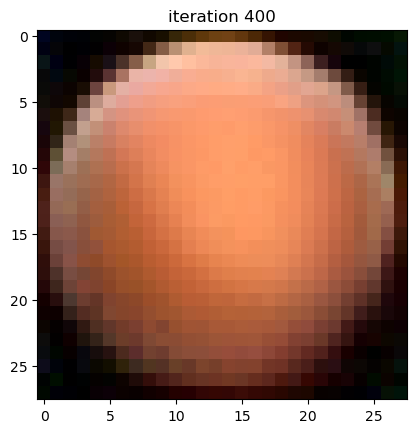

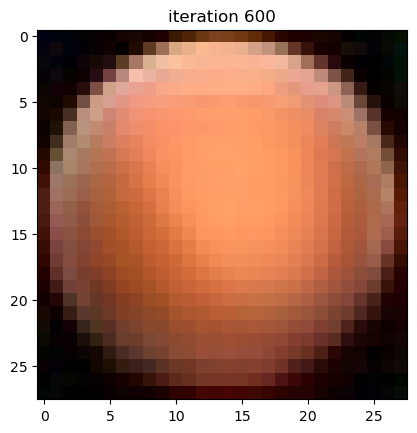

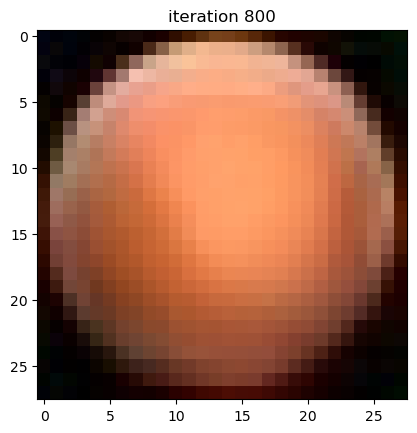

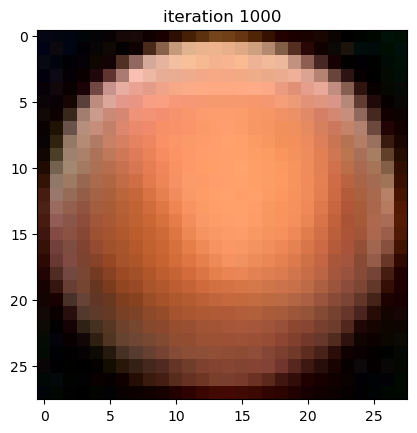

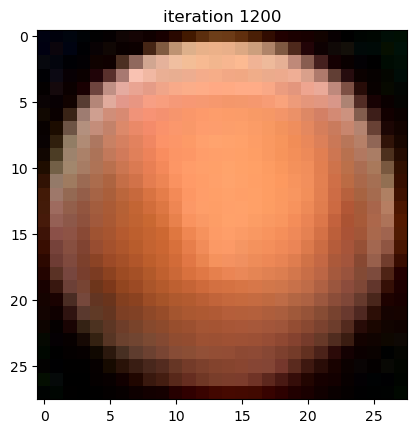

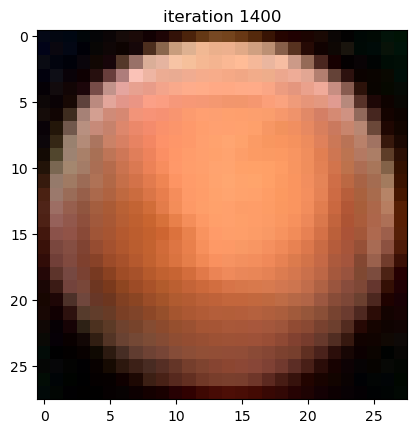

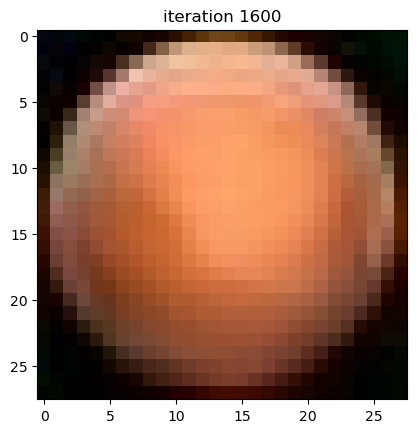

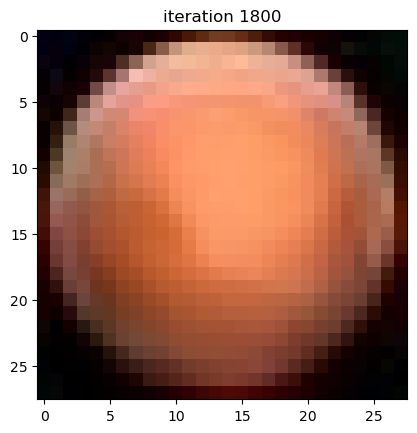

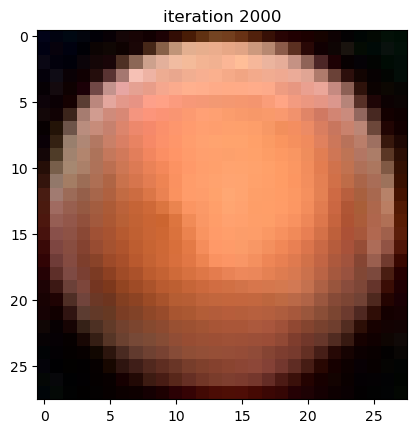

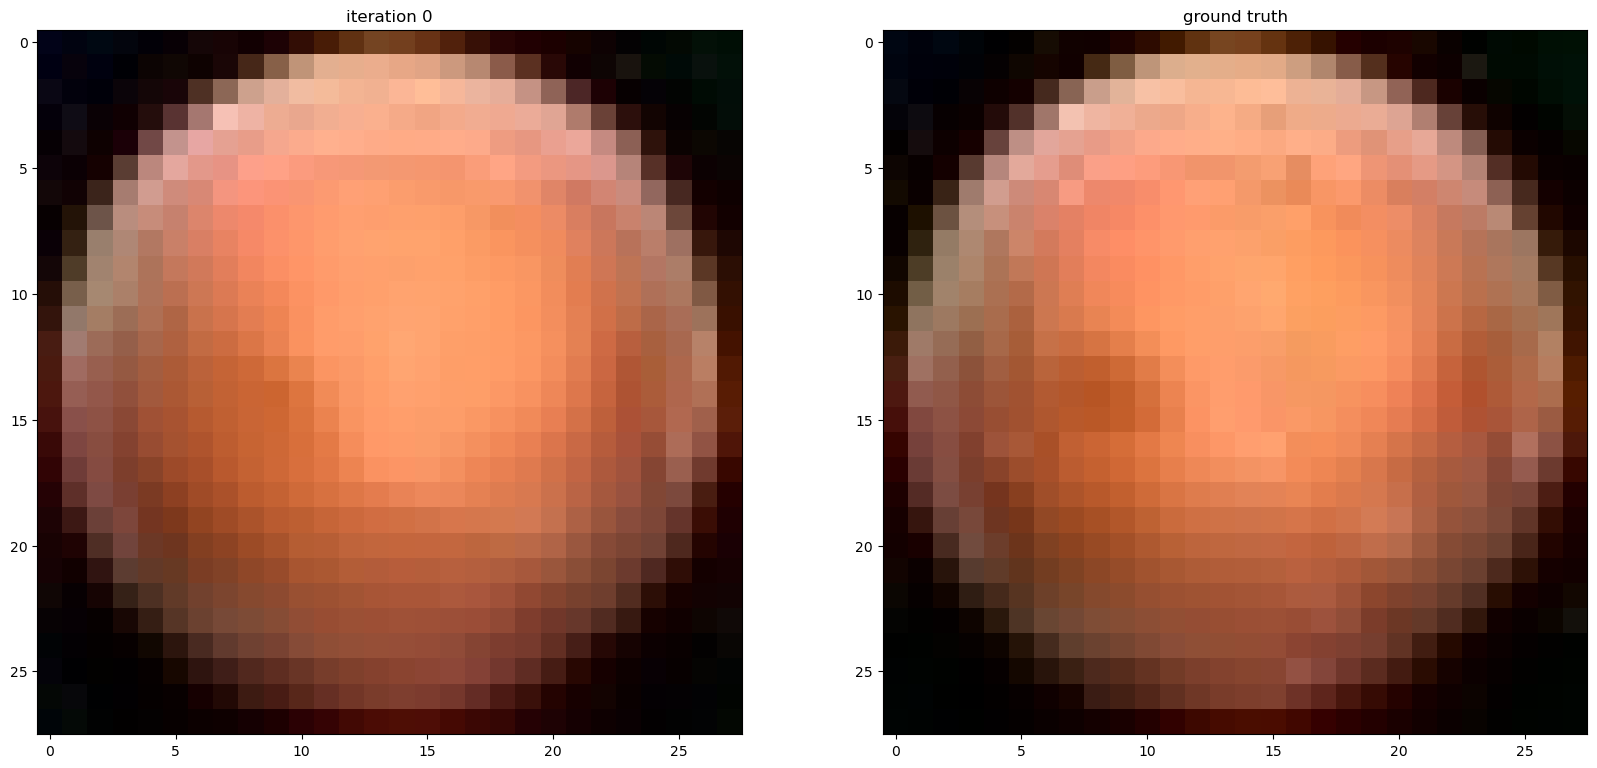

In [17]:
img = "../data/retina.png"
batch_size = 8
device = "mps"
eval_frequency = 200 #500
eval_iterations = 200 #300
n_batches = 2000 + 1# 5000 + 1
n_channels = 16
logdir = "logs"
padding = 0 #8
pool_size = 1024
size = 28

# Misc
device = torch.device(device)

log_path = pathlib.Path(logdir)
log_path.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_path)

# Target image
target_img_ = load_image(img, size=size)
p = padding
target_img_ = nn.functional.pad(target_img_, (p, p, p, p), "constant", 0)
target_img = target_img_.to(device)
target_img = target_img.repeat(batch_size, 1, 1, 1)

writer.add_image("ground truth", to_rgb(target_img_)[0])

# Model and optimizer
model = CAModel(n_channels=n_channels, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# Pool initialization
seed = make_seed(size, n_channels).to(device)
seed = nn.functional.pad(seed, (p, p, p, p), "constant", 0)
pool = seed.clone().repeat(pool_size, 1, 1, 1)

for it in tqdm(range(n_batches)):
    batch_ixs = np.random.choice(
            pool_size, batch_size, replace=False
    ).tolist()

    x = pool[batch_ixs]
    for i in range(np.random.randint(64, 96)):
        x = model(x)

    loss_batch = ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])
    loss = loss_batch.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    writer.add_scalar("train/loss", loss, it)

    argmax_batch = loss_batch.argmax().item()
    argmax_pool = batch_ixs[argmax_batch]
    remaining_batch = [i for i in range(batch_size) if i != argmax_batch]
    remaining_pool = [i for i in batch_ixs if i != argmax_pool]

    pool[argmax_pool] = seed.clone()
    pool[remaining_pool] = x[remaining_batch].detach()

    subplots = []

    if it % eval_frequency == 0:
        x_eval = seed.clone()  # (1, n_channels, size, size)

        eval_video = torch.empty(1, eval_iterations, 3, *x_eval.shape[2:])

        for it_eval in range(eval_iterations):
            x_eval = model(x_eval)
            x_eval_out = to_rgb(x_eval[:, :4].detach().cpu())
            eval_video[0, it_eval] = x_eval_out

        plt.imshow(x_eval_out[0].permute(1, 2, 0))
        plt.title(f"iteration {it}")
        plt.savefig(f"../pictures/retina/{it}.png", bbox_inches="tight")
        plt.show()        

        # save the last image of the evaluation for the plot
        subplots.append(x_eval_out[0].permute(1, 2, 0))

        writer.add_video("eval", eval_video, it, fps=60)

# show the evolution of the image as a plot
ncols = len(subplots) + 1
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10, 10), dpi=100)
axs = axs.ravel()
for i, subplot in enumerate(subplots):
    axs[i].imshow(subplot)
    axs[i].set_title(f"iteration {i * eval_frequency}")

# include the ground truth in the plot
axs[-1].imshow(to_rgb(target_img_)[0].permute(1, 2, 0)) # ground truth
axs[-1].set_title("ground truth")
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs